# Filtrado colaborativo: K-Nearest Neighbors





1. Determinar la **similaridad entre los usuarios**.
2. Encontrar el conjunto de **k usuarios más similares (k-vecinos)**.
3. **Estimar las predicciones** a los items no votados utilizando las votaciones realizadas por los k vecinos.
4. (Opcional) **Recomendar los 'N' items con la predicción más alta.

In [1]:
# Definimos dos constantes con el número de usuarios e items
NUM_USERS = 6
NUM_ITEMS = 12

def read_ratings_matrix(file):
    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)] 
    
    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)
            
    return ratings

In [2]:
import numpy as np
import pandas as pd
import warnings
from tqdm.notebook import tqdm

pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")

# Leemos el fichero y lo pasamos a una matriz (lista de listas)
RATINGS_FILE = './data.txt'
ratings_matrix = read_ratings_matrix(file=RATINGS_FILE)

# Mostramos la matriz de votos a modo informativo
pd.DataFrame(data=np.array([np.array(xi) for xi in ratings_matrix]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["I{}".format(str(i)) for i in range(NUM_ITEMS)])

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11
U0,1,2,None,None,2,None,3,4,None,4,1,None
U1,None,None,1,5,None,5,3,1,None,5,2,1
U2,1,None,None,2,None,1,None,3,4,None,None,None
U3,None,1,4,4,None,None,3,None,5,4,None,1
U4,2,None,5,None,1,None,1,None,None,None,2,1
U5,None,None,5,2,1,None,None,4,None,1,None,2


###  Métricas de Similaridad tradicionales: MSD, Coseno y Correlación de Pearson
***MSD*** (*Mean Squared Difference| Diferencia Cuadrática Media*): Para que 1 sean la similaridad máxima y 0 la similaridad mínima el valor del MSD se invertirse ($1-MSD$) para lograr que cuanto más se parezcan dos usuarios, mayor sea su similaridad y viceversa.

### $$sim(u,v)=1-MSD(u,v) = 1-\frac{1}{\#I_{u,v}}\sum_{i\in I_{u,v}}\left (  \frac{r_{u,i}-r_{v,i}}{max-min}\right )^2 \in \left [ 0,1 \right ]$$

***Coseno***

### $$sim(u,v) = \frac{\displaystyle \sum_{i\in I_{u,v}}r_{u,i} \cdot r_{v,i}}{\sqrt{\displaystyle \sum_{i\in I_{u,v}}r_{u,i}^2} \cdot \sqrt{\displaystyle \sum_{i\in I_{u,v}}r_{v,i}^2}} \in \left [ 0,1 \right ]$$

***Correlación de Pearson***

### $$sim(u,v) = \frac{\displaystyle \sum_{i\in I_{u,v}}(r_{u,i}-\bar{r_{u}})\cdot(r_{v,i}-\bar{r_{v}})}{\sqrt{\displaystyle \sum_{i\in I_{u,v}}(r_{u,i}-{\bar{r_{u}})^2} \cdot \displaystyle \sum_{i\\in I_{u,v}}(r_{v,i}-{\bar{r_{v}})^2}}} \in \left [ -1,1 \right ]$$
    
***NOTA***: *Al tener la Correlación valores de entre $[-1,1]$ deben de normalizarse estas similaridades por usuario para poder calcular posteriormente las predicciones.

* En las formulas anteriormente propuestas tenemos:
    1. $\#I_{u,v}$ representa el conjunto de los items que han votado tanto el usuario $u$ como el usuario $v$.
    2. $max$ representa el valor del voto máximo.
    3. $min$ representa el valor del voto mínimo.
    4. $\bar{r}_u$ representa la votación media del usuario $u$.
    5. $\bar{r}_v$ representa la votación media del usuario $v$.

In [3]:
def cosine_similarity(u, v):
    
    numerador = 0
    denominador_u = 0
    denominador_v = 0
    
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None

## Cálculo de similaridades

* Una vez que ya tenemos definidas las métricas de similaridad, procedemos a calcular las similaridades de todos los usuarios con todos.

* El resultado de esta tarea será la de una matriz de dimensión "NUM USERS x NUM USERS" donde estarán calculadas las similaridades entre cada par de usuarios.

* A continuación creamos la función "calculate_similarities()" a la que pasaremos como parámetros la matriz de votos y una métrica de similaridad implementada anteriormente:

In [4]:
import math
def calculate_similarities(ratings_matrix, similarity_metric):
    
    # Creamos una matriz con valores de similaridad a -infinito
    similarities = [[float('-inf') for _ in range(NUM_USERS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz por usuario
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u,v)
        
    return similarities
    

# Vamos a realizar los cálculos de la similaridad usando el Coseno
similarities = calculate_similarities(ratings_matrix=ratings_matrix, similarity_metric=cosine_similarity) 

In [5]:
pd.DataFrame(data=np.array([np.array(xi) for xi in similarities]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["U{}".format(str(i)) for i in range(NUM_USERS)])

,U0,U1,U2,U3,U4,U5
U0,-inf,0.86,1.00,0.98,0.73,0.86
U1,0.86,-inf,0.67,0.91,0.60,0.51
U2,1.00,0.67,-inf,0.98,1.00,0.99
U3,0.98,0.91,0.98,-inf,0.91,0.83
U4,0.73,0.60,1.00,0.91,-inf,0.98
U5,0.86,0.51,0.99,0.83,0.98,-inf


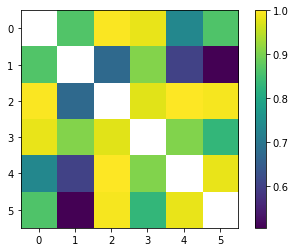

In [6]:
import matplotlib.pyplot as plt
plt.imshow(similarities);
plt.colorbar()
plt.show()

## Búsqueda de los *k-vecinos*

* Conceptualmente la búsqueda de los k-vecinos es sencillo ya que consiste en ordenar por similaridad (de mayor a menor similaridad) a los vecinos del usuario activo y quedarnos con lo 'K' más similares.
* Computacionalmente hay que recordar que las tareas de ordenación son especialmente costosas, por lo que hay que tener cuidado como realizar estas ordenaciones.
* Por último tenemos que definir previamente un valor de 'K' para seleccionar el número de vecinos.
* Pasamos a implementar la funcion "calculate_neighbors()" al que le pasaremos la matriz de similaridades y el número de vecinos a calcular y nos devolverá una matriz de "NUM_USERS x K-NEIGHBORS", indicando en cada fila el ídentificador de los vecinos del usuario:

In [7]:
# Definimos como constante el número de 'K' vecinos
K = 2

def calculate_neighbors(similarities_matrix, k_neighbors):
    
    neighbors = [None for _ in range(NUM_USERS)]
    
    for index, similarities in enumerate(tqdm(similarities_matrix, leave=False)):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities), 
                                            key=lambda x:float('-inf') if x[1] is None else x[1], 
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

neighbors = calculate_neighbors(similarities_matrix=similarities, k_neighbors=K)

In [8]:
pd.DataFrame(data=np.array([np.array(xi) for xi in neighbors]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["K{}".format(str(i)) for i in range(K)])

,K0,K1
U0,2,3
U1,3,0
U2,4,0
U3,0,2
U4,2,5
U5,2,4


In [9]:
aux_sim = [[similarities[index_u][neighbord] for index_j, neighbord in enumerate(user)] 
           for index_u, user in enumerate(neighbors)]
pd.DataFrame(data=np.array([np.array(xi) for xi in aux_sim]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["K{}".format(str(i)) for i in range(K)])

,K0,K1
U0,1.00,0.98
U1,0.91,0.86
U2,1.00,1.00
U3,0.98,0.98
U4,1.00,0.98
U5,0.99,0.98


## Estimar las predicciones

### Average

* Consiste en dar como predicción del voto, el valor medio del voto de los vecinos que hayan votado el item a recomendar:
    
    $$\hat{r}_{u,i} = \frac{1}{\#N_{u,i}} \sum_{n \in N_{u,i}} r_{n,i}$$
    

* Pasamos a implementar la funcion \"calculate_average_prediction()\" al que le pasaremos la matriz de votos y los *K-vecinos* y nos devolverá una matriz de \"*NUM_USERS x NUM_ITEMS*\", con las predicciones:

In [10]:
def calculate_average_prediction(ratings_matrix, neighbors):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        for j, v in enumerate(ratings_matrix[0]):

            # Obtenemos las votaciones de cada vecino y calculamos el voto medio
            sum_r = 0 
            count = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    count += 1
                    sum_r += ratings_matrix[neighbor][j]
                    
            predictions[i][j] = None if count == 0 else sum_r/count
            
    return predictions
            
predictions_avg = calculate_average_prediction(ratings_matrix=ratings_matrix, neighbors=neighbors)

In [11]:
pd.DataFrame(data=np.array([np.array(xi) for xi in predictions_avg]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["I{}".format(str(i)) for i in range(NUM_ITEMS)])

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11
U0,1.00,1.00,4.00,3.00,None,1.00,3.00,3.00,4.50,4.00,None,1.00
U1,1.00,1.50,4.00,4.00,2.00,None,3.00,4.00,5.00,4.00,1.00,1.00
U2,1.50,2.00,5.00,None,1.50,None,2.00,4.00,None,4.00,1.50,1.00
U3,1.00,2.00,None,2.00,2.00,1.00,3.00,3.50,4.00,4.00,1.00,None
U4,1.00,None,5.00,2.00,1.00,1.00,None,3.50,4.00,1.00,None,2.00
U5,1.50,None,5.00,2.00,1.00,1.00,1.00,3.00,4.00,None,2.00,1.00


# Cálculo de las recomendaciones

* Una vez que tenemos calculadas las predicciones tenemos que recomendar a cada usuario 'N' items que no ha valorado, ordenados por la nota de la predicción.

* Veamos a continuación como realizar la recomendación, implementando la función "make_recommendations()" que recibe como parámetros el número de recomendaciones a realizar, la matrix de votos y la matriz de predicciones y devuelve una matriz con los items a recomendar. Esta función recorrerá la matriz de votos, vera los items no votados y recomendaremos esos items a los usuarios ordenandolos por la predicción del voto, truncando el número de recomendaciones a las indicadas por la función:

In [12]:
N = 12

def make_recommendations(num_recomendations, ratings_matrix, predictions_matrix):
    
    # Creamos una matriz para las recomendaciones
    recommendations = [[(None, None) for _ in range(num_recomendations)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] == None:
                recommendations[i].append((j, predictions_matrix[i][j]))
        
        # Ordenamos los items a recomendar al usuario
        recommendations[i] = sorted(recommendations[i], 
                                    key=lambda x:float('-inf') if x[1] is None else x[1], 
                                    reverse=True)[0:num_recomendations]

    return [[x[0] for x in reco_user] for reco_user in recommendations]

                
recomendations = make_recommendations(num_recomendations=N,
                                      ratings_matrix=ratings_matrix,
                                      predictions_matrix=predictions_avg)

In [13]:
pd.DataFrame(data=np.array([np.array(xi) for xi in recomendations]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["Reco{}".format(str(i+1)) for i in range(N)])

,Reco1,Reco2,Reco3,Reco4,Reco5,Reco6,Reco7,Reco8,Reco9,Reco10,Reco11,Reco12
U0,8,2,3,5,11,None,None,None,None,None,None,None
U1,8,4,1,0,None,None,None,None,None,None,None,None
U2,2,9,1,6,4,10,11,None,None,None,None,None
U3,7,4,0,5,10,None,None,None,None,None,None,None
U4,8,7,3,5,9,None,None,None,None,None,None,None
U5,8,10,0,5,6,None,None,None,None,None,None,None


# Evaluación del sistema de Recomendación

Por último vamos a calcular el error medio (MAE) cometido en las predicciones realizadas.



* Recordar que definimos el MAE de un usuario como:
    $$MAE_u = \frac{ \sum_{i \in I^T_u} \mid r_{u,i} - \hat{r}_{u,i} \mid  }{\#I^T_u} $$
  
  
donde $I^T_u$ representa el conjunto de items de test votados por el usuario $u$.
    
* Definimos el *MAE* del sistema como el promedio del *MAE* de cada usuario:

    $$MAE = \frac{ \sum_{u \in U^T} MAE_u }{ \#U^T } $$

In [14]:
def get_mae(ratings_matrix, predictions_matrix):
    
    mae_users = [None for _ in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(tqdm(ratings_matrix, leave=False)):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)


mae_avg_predictions = get_mae(ratings_matrix=ratings_matrix, 
                              predictions_matrix=predictions_avg)


print('MAE con avg_predictions: {:0.4f}'.format(mae_avg_predictions))


MAE con avg_predictions: 0.6893
